<font color="">**ENG5337**</font>  
<font color="">**Convolution Neural Network**</font>  
<font color="">**Lecturer**</font>&nbsp; <font color="DeepSkyBlue">*Khiem Nguyen*</font> - *James Watt School of Engeering  University of Glasgow*

# Convolution Neural Network for image classification

**Structure of this notebook**  

The notebook will be split into two main parts:
- The first part is to explain several key concepts in Convolution Neural Network and implementation practices in PyTorch. It serves as a quick warm-up and refresh your knolwedge before working on a real application.
- The second part is to deal with a real application: Classification of hand-written digits.

**Problem Description**

In this notebook, we will build a rather simple *convolution neural network* to classify hand-written digits from $0$ to $9$. This problem has been dealt with using a deep fully connected neural network (multilayer perceptrons) in the "Deep Neural Network" week. We have achieved an impressive accuracy score by using a deep neural network ($\geq 95\%$). Our goal is to build a custom convolution neural network to solve this multi-class classification problem. It will be shown after finishing this Jupyter Notebook that the prediction accuracy can still be improved by a very good margin. In the end of the notebook, you will see that the accuracy score can reach to more $99\%$ or even more. 

## <font color='DeepSkyBlue'>Part 1: Warm Up</font>

As mentioned above, the first part will provide you with some useful information about representation of digital images, key concepts of convolution neural networks and implementation practices in training a CNN in PyTorch.

### Understanding representation of digital images 

While convolutional neural networks (CNNs) see a wide variety of uses, they were originally designed for images, and CNNs are still most commonly used for vision-related tasks.
For today, we'll primarily be focusing on CNNs for images. Before we dive into convolutions and neural networks, it's worth prefacing with how images are represented by a computer, as this understanding will inform some of our design choices. Previously, we saw an example of a digitized MNIST handwritten digit. Specifically, we represent it as an $H \times W$ table, with the value of each element storing the intensity of the corresponding pixel.

With a 2D representation as above, we for the most part can only efficiently represent grayscale images. *What if we want color?* There are many schemes for storing color, but one of the most common ones is the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model). In such a system, we store 3 tables of pixel intensities (each called a *channel*), one each for the colors red, green, and blue (hence RGB), resulting in an $H \times W \times 3$ tensor. Pixel values for a particular channel indicate how much of the corresponding color the image has at a particular location.

In this section, our goal is to understand how images are stored and shown digitally in Python and how PyTorch handles a batch of color images, i.e., a set of images.

Let's load an image and see

Shape of the image tensor: (783, 1188, 3)


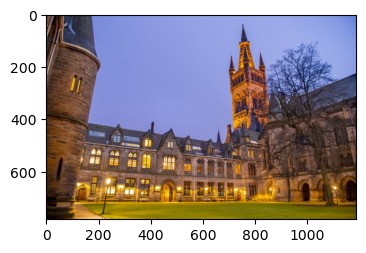

In [1]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
# If you use this command
# imageio.imread("./images/uog.jpg")
# Python will issue a warning about the version. 
# I hate warning, so I follow its instruction and use the following statement.

im = imageio.v3.imread("./images/uog.jpg") # v3 means version 3. v2 may be deprecated in the future
print("Shape of the image tensor: {}".format(im.shape))
plt.figure(figsize=(4, 2.8))
plt.imshow(im)
plt.show()

We can see that the image we loaded has height and width of $783 \times 1188$, with 3 channels corresponding to Red-Green-Blue. We can easily slice out and view individual color channels:

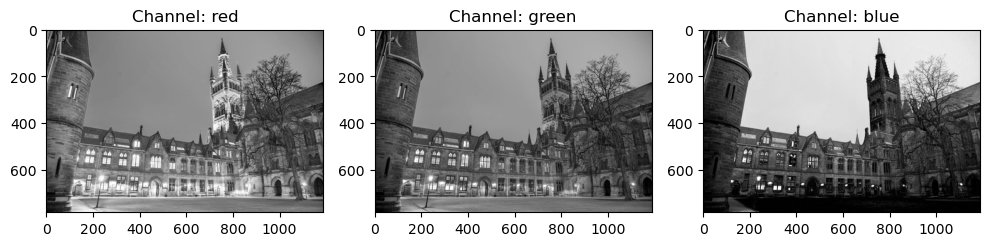

In [2]:
plt.figure(figsize=(10, 3.0))
channel = ['red', 'green', 'blue']
for i in range(3):
    plt.subplot(1,3,i+1)
    im_channel = im[:,:,i]
    plt.imshow(im_channel, cmap='gray')
    plt.title(f"Channel: {channel[i]}")
plt.tight_layout()
plt.show()

While we have so far considered only 3 channel RGB images, there are many settings in which we may consider a different number of channels. For example, [hyperspectral imaging](https://en.wikipedia.org/wiki/Hyperspectral_imaging) uses a wide range of the electromagnetic spectrum to characterize a scene. Such modalities may have hundreds of channels or more. Additionally, we'll soon see that certain intermediate representations in a CNN can be considered images with many channels. However, we'll focus much of today's discussion to 1 channel grayscale and 3 channel RGB images as our inputs, as is most commonly the case in computer vision.

### Theoretical background: Convolution

Convolutional neural networks (CNNs) are a class of neural networks that have convolutional layers. CNNs are particularly effective for data that have spatial structures and correlations (e.g. images).
We'll focus on CNNs applied to images in this notebook. Recall that a multilayer perceptron (MLP) is entirely composed of fully connected layers, which are each a matrix multiply operation (and addition of a bias) followed by a non-linearity (e.g. sigmoid, ReLU). A convolutional layer is similar, except the matrix multiply operation is replaced with a convolution operation (in practice a cross-correlation). 
Note that a CNN need not be entirely composed of convolutional layers; in fact, many popular CNN architectures end in fully connected layers.

#### Quick review of fully connected layer
In a fully connected layer, the input $\mathbf{X} \in \mathbb R^{M \times n_\text{in}}$ is a vector (or, rather a batch of vectors), where $M$ is the minibatch size and $n_\text{in}$ is the dimensionality of the input. 
We first matrix multiply the input $\mathbf{X}$ by a weight matrix $\mathbf{W}$. This weight matrix has dimensions $\mathbf{W} \in \mathbb{R}^{n_{out} \times n_{in}}$, where $b_{out}$ is the number of output units. We then add a bias for each output, which we do by adding $\mathbf{b} \in \mathbb{R}^{n_{out}}$. The output $\mathbf{y} \in \mathbb{R}^{M \times n_{out}}$ of the fully connected layer then:
$$
y = \mathrm{ReLU}(\mathbf{X} \mathbf{W}^{T} + b)
$$
Remember, the values of $\mathbf{W}$ and $\mathbf{b}$ are parameters that we are trying to learn for our model.


#### Convolutional layer

In a convolutional layer, we convolve the input $x$ with a convolutional kernel (aka filter), which we also call $\mathbf{W}$, producing output $\mathbf{y}$:
$$
\mathbf{y} = \mathrm{ReLU}(\mathbf{W} \ast \mathbf{X} + \mathbf{b})
$$
Note that the asterisk $\ast$ refer to the convolution operation defined our lectures. Remark: *Do not confuse it with convolution in mathematics or other subjects in electrical engineering*. In the context of CNNs, the output $\mathbf{y}$ is often referred to as <font color="magenta">**feature maps**</font>. As with a fully connected layer, the goal is to learn $\mathbf{W}$ and $\mathbf{b}$ for our model.

Unlike the input of a fully connected layer, which is $\mathbf{X} \in \mathbb R^{M\times n_\text{in}}$, the dimensionality of an image input is $4$D: $\mathbf{X} \in \mathbb R^{M \times C_\text{in} \times H_{in} \times W_\text{in}}$, where $M$ is still the batch size, $C_\text{in}$ is the number of channels of the input (e.g. 3 for RGB), and $H_{in}$ and $W_{in}$ are the height and width of the image. Although we may view the number of neurals $n_\text{in}$ in a linear layer somewhat in the role number of channels $C_\text{in}$ in a convolution layer, they actually carry different meanings in essence.

The weight parameter $\mathbf{W}$ is also different in a convolutional layer. Unlike the $2$-D weight matrix for fully connected layers, the kernel is $4$-D with dimensions $\mathbf{W} \in \mathbb R^{C_{out} \times C_{in} \times H_\text{ker} \times W_\text{ker}}$, where $H_\text{ker}$ and $W_\text{ker}$ are the kernel height and weight, respectively. A common choice for $H_\text{ker}$ and $W_\text{ker}$ is $H_\text{ker} = W_\text{ker} = 3$ or $5$, but this tends to vary depending on the architecture. Convolving the input with the kernel and adding a bias then gives an output $\mathbf{y} \in \mathbb{R}^{M \times C_\text{out} \times H_\text{out} \times W_\text{out}}$. If we use "same" padding and a stride of $1$ in our convolution (more on this later), our output will have the same spatial dimensions as the input: $H_\text{out} = H_\text{in}$ and $W_\text{out}=\text{W}_{in}$.

If you're having trouble visualizing this operation in $4$D, it's easier to think about for a single member of the minibatch, one convolutional kernel at a time. Consider a stack of $C_\text{out}$ number of kernels, each of which are $3$-D ($C_\text{in} \times H_\text{ker} \times W_\text{ker} $). This $3$-D volume is then slid across the input (which is also 3D: $C_\text{in} \times H_\text{in} \times W_\text{in}$) in the two spatial dimensions (along $H_\text{in}$ and $W_\text{in}$). The outputs of the multiplication of the kernel and the input at every location creates a single feature map that is $H_\text{out} \times W_\text{out}$. Stacking the feature maps generated by each kernel gives the $3$-D output $C_\text{out} \times H_\text{out} \times W_\text{out} $. Repeat the process for all $M$ inputs in the minibatch, and we get a $4$-D output $M  \times C_\text{out} \times H_\text{out} \times W_\text{out}$.


**Important things to note**

- Notice the ordering of the dimensions of the input (batch, channels, height, width). This is commonly referred to as $NCHW$ ordering. Many other languages and libraries (e.g. MATLAB, TensorFlow, the image example at the beginning of this notebook) instead default to the slightly different $NHWC$ ordering. PyTorch defaults to $NCHW$, as it more efficient computationally, especially with CUDA. 
- An additional argument for the convolution is the `stride`, which controls the how far we slide the convolutional filter as we move it along the input image. The convolutional operator, from its signal processing roots, by default considers a stride length of $1$ in all dimensions, but in some situations we would like to consider strides more than $1$ (or even less than $1$). More on this later.
- In the context of signal processing, convolutions usually result in outputs that are larger than the input size, which results from when the kernel "hangs off the edge" of the input on both sides. 
This might not always be desirable. We can control this by controlling the padding of the input. Typically, we use pad the input to ensure the output has the same spatial dimensions as the input (assuming stride of $1$); this makes it easier for us to keep track of what the size of our model is.

In [3]:
# First thing first: import useful packages and modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
%matplotlib inline
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

Let's implement this convolution operator in code.
There is a convolution implementation in `torch.nn.functional`, which we use here.

In [4]:
# Create a random image input tensor
x_cnn = torch.randn(100, 1, 28, 28)

# Create convolutional kernel variable
W1 = torch.randn(16, 1, 3, 3)/np.sqrt(1*3*3)
W1.requires_grad_()

# Create bias variable
b1 = torch.zeros(16, requires_grad=True)

# Apply convolutional layer
conv1_pre_activation = F.conv2d(x_cnn, W1, bias=b1, stride=1, padding=1)
conv1 = F.relu(conv1_pre_activation)

# Print input/output shape
print(f"Input shape: {x_cnn.shape}")
print(f"Convolution output shape: {conv1.shape}")

Input shape: torch.Size([100, 1, 28, 28])
Convolution output shape: torch.Size([100, 16, 28, 28])


Just like in a MLP, we can stack multiple of these convolutional layers. In the *Understanding representation of digital images * section, we briefly mentioned considering images with channels more than $3$.
Observe that the input to the second layer (i.e. the output of the first layer) can be viewed as an "image" with $C_\text{out}$ channels. Instead of each channel representing a color content though, each channel effectively represents how much the original input image activated a particular convolutional kernel. Given $C_\text{out}$ kernels that are each $C_\text{in} \times H_\text{ker} \times W_\text{ker}$, this results in $C_\text{out}$ channels for the output of the convolution.

**Remark**  
Note that we need to change the dimensions of the convolutional kernel such that its input channels matches the number of output channels of the previous layer:

In [5]:
# 2nd layer variables
W2 = torch.randn(32, 16, 3, 3)/np.sqrt(16*3*3)
W2.requires_grad_()
b2 = torch.zeros(32, requires_grad=True)

# Apply 2nd convolutional layer
conv2 = F.relu(F.conv2d(conv1, W2, bias=b2, stride=1, padding=1))

# Print output shape
print("Second convolution output shape: {}".format(conv2.shape))

Second convolution output shape: torch.Size([100, 32, 28, 28])


In fact, we typically perform these convolution operations many times. Popular CNN architectures for image analysis today can be 100+ layers.

### Reshaping

You'll commonly finding yourself needing to reshape tensors while building CNNs. The PyTorch function for doing so is `view()`. Anyone familiar with NumPy will find it very similar to `np.reshape()`. Importantly, the new dimensions must be chosen so that it is possible to rearrange the input into the shape of the output (i.e. the total number of elements must be the same). As with NumPy, you can optionally replace one of the dimensions with a `-1`, which tells `torch` to infer the missing dimension.

In [6]:
M = torch.zeros(4, 3)

M2 = M.view(1,1,12)
M3 = M.view(2,1,2,3)
M4 = M.view(-1,2,3)
M5 = M.view(-1)

To get an idea of why reshaping is needed in CNN, let us imagine the following situation. the CNN expects a 4D input, with the dimensions corresponding to `[batch, channel, height, width]`.
Your data may not come in this format because it was already reshaped for some other computational operations, so you may have to reshape it yourself.

In [7]:
# Reshape flat input image into a 4D batched image input
x_flat = torch.randn(100, 784)      # 100 images of grayscale, 784 = 28 * 28
x_reshaped = x_flat.view(-1, 1, 28, 28)

# Print input shape
print(x_reshaped.shape) # 100 images, 1 channel (grayscale), H x W = 28 x 28

torch.Size([100, 1, 28, 28])


CNN architectures also commonly contain fully connected layers or a softmax, as we're often interested in classification. Both of these expect 2D inputs with dimensions `[batch, dim]`, so you have to "flatten" a CNN's $4$-D output to $2$-D. For example, to flatten the convolutional feature maps we created earlier:

In [8]:
# Flatten convolutional feature maps into a vector
h_flat = conv2.view(-1, 28*28*32)

# Print output shape
print(h_flat.shape)

torch.Size([100, 25088])


### Pooling and striding

Almost all CNN architectures incorporate either pooling or striding. This is done for a number of reasons, including:
- Dimensionality reduction: pooling and striding operations reduces computational complexity by shrinking the number of values passed to the next layer.
For example, a 2x2 maxpool reduces the size of the feature maps by a factor of 4.
- Translational invariance: Oftentimes in computer vision, we'd prefer that shifting the input by a few pixels doesn't change the output. Pooling and striding reduces sensitivity to exact pixel locations.
- Increasing receptive field: by summarizing a window with a single value, subsequent convolutional kernels are seeing a wider swath of the original input image. For example, a max pool on some input followed by a 3x3 convolution results in a kernel "seeing" a 6x6 region instead of 3x3.

#### Pooling
The two most common forms of pooling are max pooling and average pooling. Both reduce values within a window to a single value, on a per-feature-map basis. Max pooling takes the maximum value of the window as the output value; average pooling takes the mean.

#### Striding
One might expect that pixels in an image have high correlation with neighboring pixels, so we can save computation by skipping positions while sliding the convolutional kernel. By default, a CNN slides across the input one pixel at a time, which we call a stride of $1$. By instead striding by $2$, we skip calculating $75\%$ of the values of the output feature map, which yields a feature map that's half the size in each spatial direction. Note, while **pooling** is an operation *done after* the convolution, **striding** is *part of* the convolution operation itself.

In [9]:
# Since striding is part of the convolution operation, we'll start with the feature maps before the 2nd convolution
print("Shape of conv1 feature maps: {0}".format(conv1.shape))

# Apply 2nd convolutional layer, with striding of 2
conv2_strided = F.relu(F.conv2d(conv1, W2, bias=b2, stride=2, padding=1))

# Print output shape
print("Shape of conv2 feature maps with stride of 2: {0}".format(conv2_strided.shape))

Shape of conv1 feature maps: torch.Size([100, 16, 28, 28])
Shape of conv2 feature maps with stride of 2: torch.Size([100, 32, 14, 14])


#### Some random, irrelevant things for generating figures in the lectures

<Figure size 500x500 with 0 Axes>

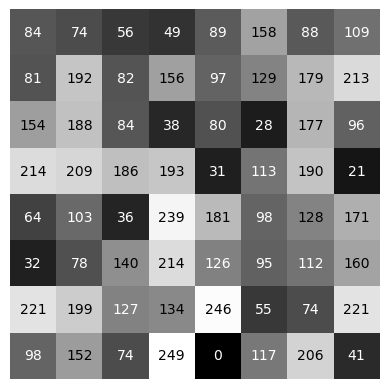

In [10]:
plt.figure(figsize=(5, 5))
img = np.random.randint(low=0, high=255, size=(8, 8))
fig, ax = plt.subplots()
plt.imshow(img, cmap='gray')
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        c = 1 if img[i,j] < 128 else 0
        ax.text(j, i, str(img[i, j]), color=(c, c, c), ha='center', va='center')
plt.axis('off')
plt.savefig('./images/pixels-with-values.jpg')

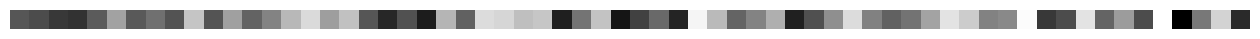

In [11]:
plt.figure(figsize=(16, 1))
img_column = img.reshape((1, -1))
plt.imshow(img_column, cmap='gray')
for i in range(img_column.shape[0]):
    for j in range(img_column.shape[1]):
        c = 1 if img_column[i,j] < 128 else 0
        ax.text(j, i, str(img_column[i, j]), color=(c, c, c), ha='center', va='center')
plt.axis("off")
plt.savefig('./images/pixels-with-values-flatten.jpg')

## <font color='DeepSkyBlue'>Part 2: Convolutional Neural Network for classification of hand-written digits</font>

In this part, we start the real business: build and train a convolution neural network for a real-world classification problem.

In [12]:
# First thing first: import useful packages and modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
%matplotlib inline
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load, preprocess and visualize data

Nothing fancy here. We just repeat mostly what we did in the Week "Deep Neural Network". You just follow along or practice again the notebook on Multi-layer Perceptrons for classification of MNIST dataset.

In [13]:
# Load the data using torchvision.datasets
mnist_train = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=60, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=60, shuffle=True)

In [14]:
train_size = len(mnist_train)
valid_size = len(mnist_test)

height = width = 28
X = np.zeros(shape=(valid_size, height, width))
y = np.zeros(shape=(valid_size,))
for i, (img, label) in enumerate(mnist_test):
    X[i] = img.squeeze()
    y[i] = label

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

X.shape = (10000, 28, 28)
y.shape = (10000,)


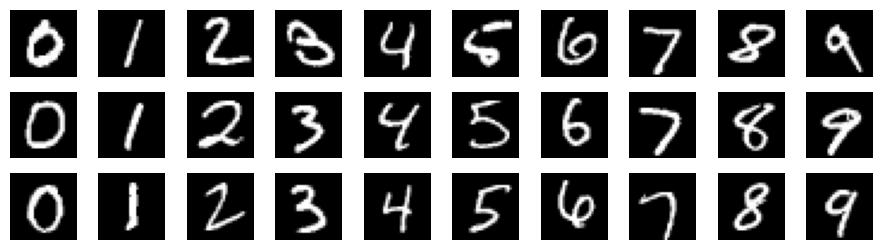

In [15]:
idx_list = []
for i in range(10):
    idx_list.append(np.where(y == i)[0][0:10])

plt.figure(figsize=(9, 2.6))
rows, cols = 3, 10
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, cols*i + j + 1)
        idx = idx_list[j]
        plt.imshow(X[idx[i]], cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.savefig('./images/mnist-digits.jpg')

Before moving on, let us look at the dimension of a batch of images. We should expect to see a batch of images has dimension $(60, 1, 28, 28)$ where $60$ is the number of images, $1$ is the number of channel of one image ($1$ because of grayscale image), $(28, 28)$ refers to the height and the width of the image.

In [16]:
data_train_iter = iter(train_loader)
images, labels = next(data_train_iter)
print(f"images.shape: {images.shape}")
print(f"labels.shape: {labels.shape}")

images.shape: torch.Size([60, 1, 28, 28])
labels.shape: torch.Size([60])


### Define Convolution Neural Network

Feel free to play around with the model architecture and see how the training time/performance changes, but to begin, we shall build a CNN model with the following architecture:

Image $\rightarrow$  
convolution $[32\quad (3 \times 3) \text{ filters}]$ $\rightarrow$ nonlinearity (ReLU) $\rightarrow$  
convolution $[32\quad (3 \times 3) \text{ filters}]$ $\rightarrow$ nonlinearity (ReLU) $\rightarrow$ $[(2 \times 2) \text{max pool}]$ $\rightarrow$  
convolution $[64\quad (3 \times 3) \text{ filters}]$ $\rightarrow$ nonlinearity (ReLU) $\rightarrow$  
convolution $[64\quad (3 \times 3) \text{ filters}]$ $\rightarrow$ nonlinearity (ReLU) $\rightarrow$ $[(2 \times 2) \text{max pool}]$ $\rightarrow$  flatten $\rightarrow$  
fully connected ($256$ hidden units) $\rightarrow$ nonlinearity (ReLU) $\rightarrow$  
fully connected ($10$ hidden units) $\rightarrow$ softmax 

**Note**  
The CNN model might take a while to train. Depending on your machine, you might expect this to take up to half an hour. If you see your validation performance start to plateau, you can kill the training.

In [17]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convolution layer 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # convolution layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # convolution layer 3
        x = self.conv3(x)
        x = F.relu(x)

        # convolution layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # fully connected layer 1
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = F.relu(x)

        # fully connected layer 2
        x = self.fc2(x)

        return x

In [18]:
# Test the forward pass
model = MNIST_CNN()
y = model(images)
print(f"output.shape: {y.shape}")

output.shape: torch.Size([60, 10])


### Train the model

Training a convolutional neural network is done in the same way of training a fully connected neural network. Only the model is built different. For this reason, the following code cells probably do not need excessive explanation. Please go back to the Jupyter Notebooks in the last learning weeks to get yourselves familiar with writing code for a model training process.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model.to(device)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [20]:
# Iterate through train set minibatchs
epochs = 3      # <---- change here
for epoch in trange(epochs):  
    for images, labels in tqdm(train_loader, total=len(train_loader)):
        # Zero out the gradients
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        y = model(images)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        # Update learnable parameters
        optimizer.step()

100%|██████████| 3/3 [00:36<00:00, 12.05s/it]


In [21]:
# Accuracy on the test set
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        x = images  # <---- change here 
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

100%|██████████| 167/167 [00:01<00:00, 140.04it/s]

Test accuracy: 0.9901999831199646
